In [1]:
import os
import numpy as np
from random import randint

RNG = np.random.default_rng(2023)
HOME = os.getenv("HOME")

In [11]:

params = np.loadtxt(f"{HOME}/Datasets/cell_migration/params3/parameters.txt")

series = [
    np.loadtxt(f"{HOME}/Datasets/cell_migration/params3/dac.txt"),
    np.loadtxt(f"{HOME}/Datasets/cell_migration/params3/msd.txt")
]

# Since series can be different length, we slice them to the same length
SLICETO = min([ s.shape[1] for s in series ])
series = [ s[:, :SLICETO] for s in series ]
series = np.array(series)

# Put in to the right shape
series = np.swapaxes(series, 0, 1)
print(params.shape)
print(series.shape)

(100000, 3)
(100000, 2, 79)


In [3]:
from bayesflow.simulation import GenerativeModel, Prior, Simulator

prior = Prior(prior_fun=lambda: params[randint(0, len(params) - 1)], param_names=["P1", "P2", "P3"])

prior_means, prior_stds = prior.estimate_means_and_stds()

/Users/alisamar/Desktop/cell_migration/.venv/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


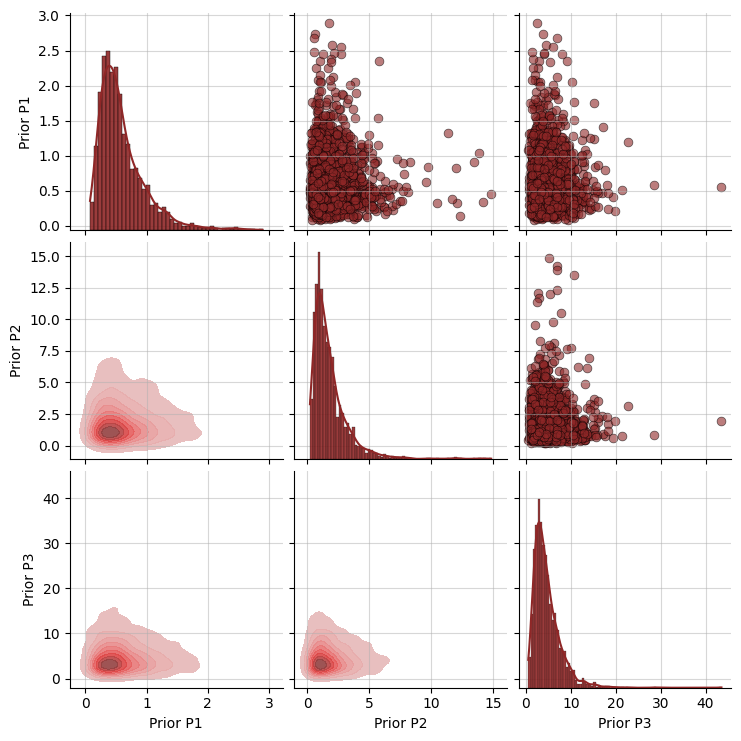

In [4]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

In [5]:
from bayesflow.networks import InvertibleNetwork, TimeSeriesTransformer
from bayesflow.amortizers import AmortizedPosterior

In [12]:
summary_net = TimeSeriesTransformer(input_dim=series.shape[1]+1)

In [13]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=4)

In [14]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="covid_amortizer")

In [15]:
from bayesflow.trainers import Trainer


def configure_input(input_dict):

    """ Function to configure the simulated quantities (i.e., simulator outputs)
        into a neural network-friendly (BayesFlow) format.
    """

    # Extract prior draws and z-standardize with previously computed means
    # prior draws are the parameters we want to estimate
    params = input_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds

    x = input_dict['sim_data']
    batch_size, _, num_timesteps  = x.shape
    # add time encoding to the data x
    time_encoding = np.linspace(0, 1, num_timesteps)
    time_encoding_batched = np.tile(time_encoding, (batch_size, 1, 1))

    return {
        "parameters": params,
        "summary_conditions": np.concatenate((x, time_encoding_batched), axis=1).reshape(batch_size, num_timesteps, -1)
    }

trainer = Trainer(amortizer=amortizer, generative_model=None, configurator=configure_input, memory=True)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


In [16]:
# train, val = reader.train_val_split(0.9)
SPLIT = int(0.9 * len(params))
train = params[:SPLIT], series[:SPLIT]
val = params[SPLIT:], series[SPLIT:]

offline_data = {
    "prior_draws": train[0],
    "sim_data": train[1],
}

validation_data = {
    "prior_draws": val[0],
    "sim_data": val[1],
}

history = trainer.train_offline(offline_data, epochs=100, batch_size=64, early_stopping=True, validation_sims=validation_data)

Training epoch 1:   2%|▏         | 34/1407 [00:07<05:12,  4.40it/s, Epoch: 1, Batch: 34,Loss: 3.677,W.Decay: 0.213,Avg.Loss: 3.867,Avg.W.Decay: 0.222,LR: 5.00E-04]


KeyboardInterrupt: 

/Users/alisamar/Desktop/cell_migration/.venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


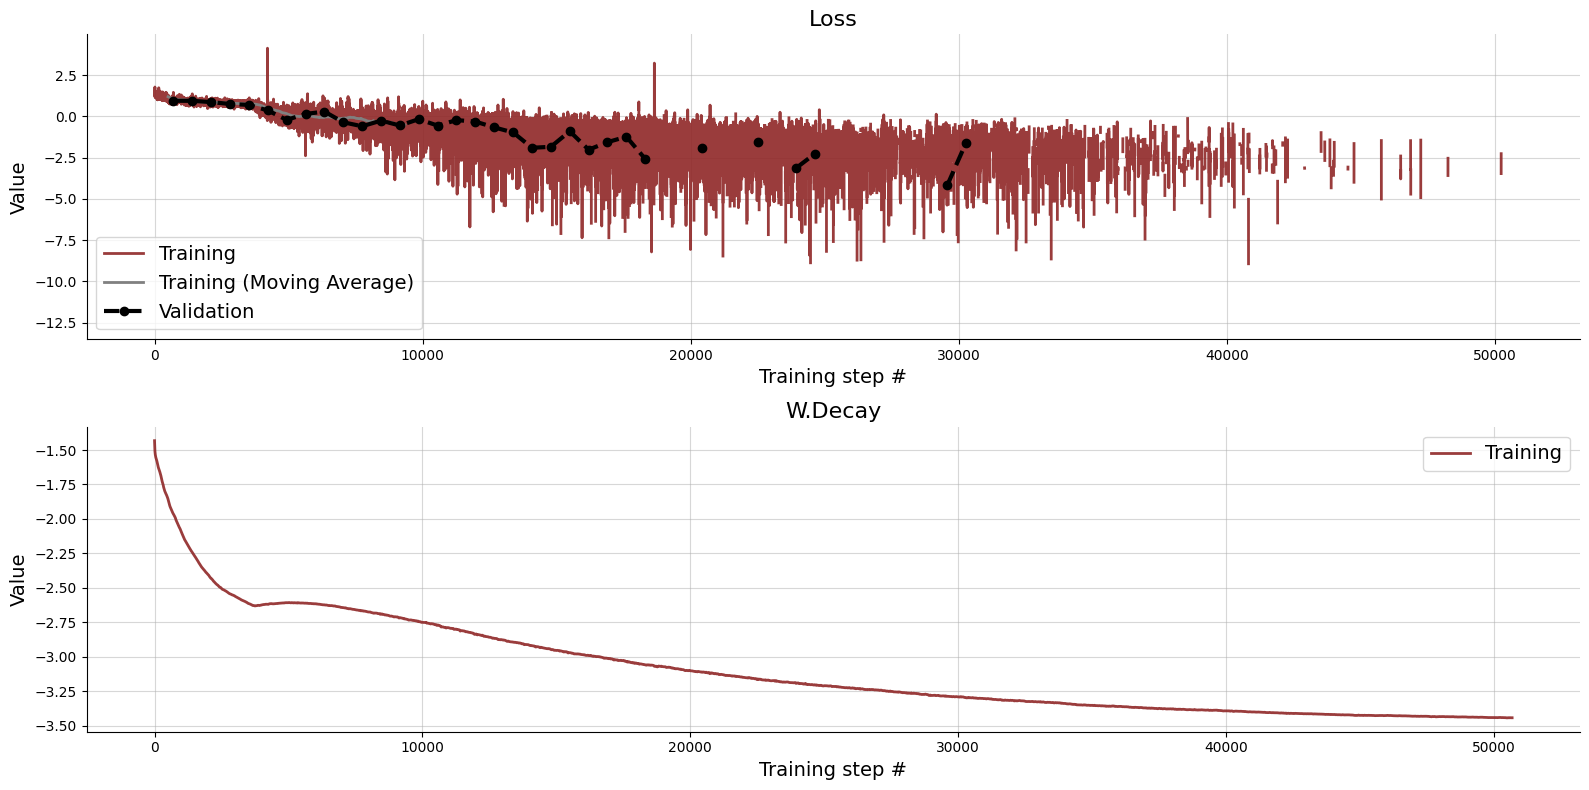

In [13]:
import bayesflow.diagnostics as diag

f = diag.plot_losses(np.log(history["train_losses"]), np.log(history["val_losses"]), moving_average=True)

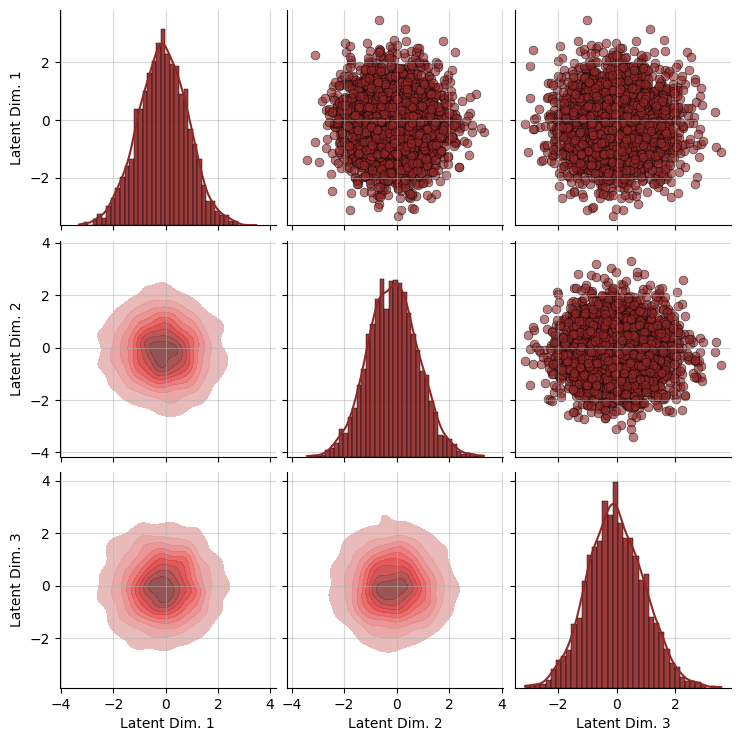

In [14]:
f = trainer.diagnose_latent2d()

In [15]:
# f = trainer.diagnose_sbc_histograms()

In [16]:
validation_sims = trainer.configurator(validation_data)

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)

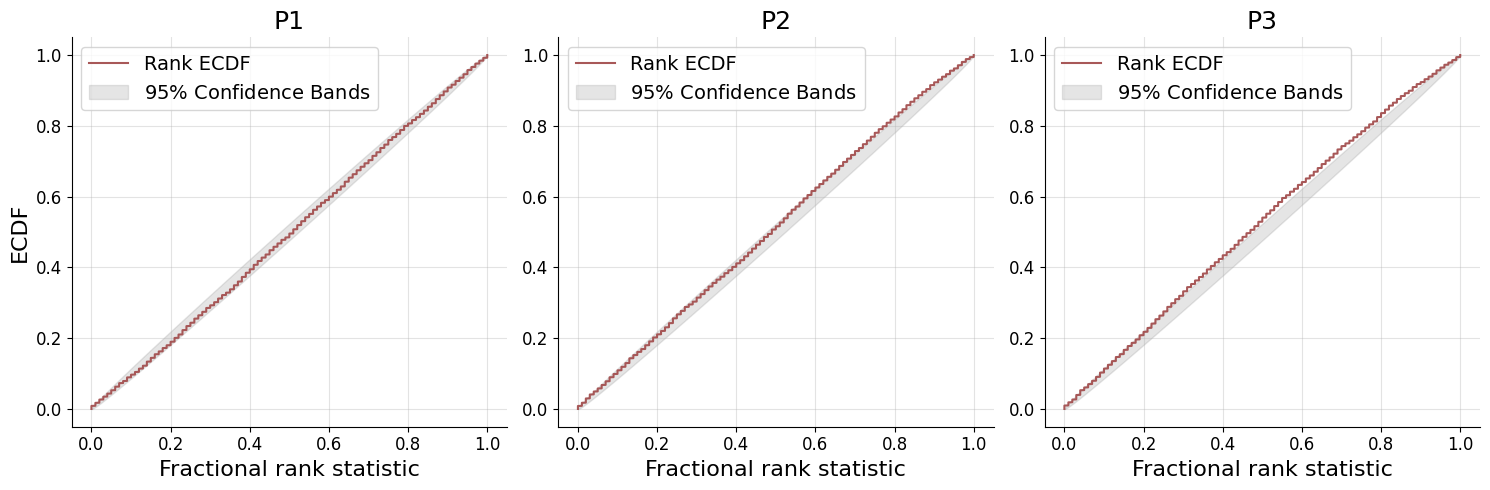

In [17]:
# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims["parameters"], param_names=prior.param_names)

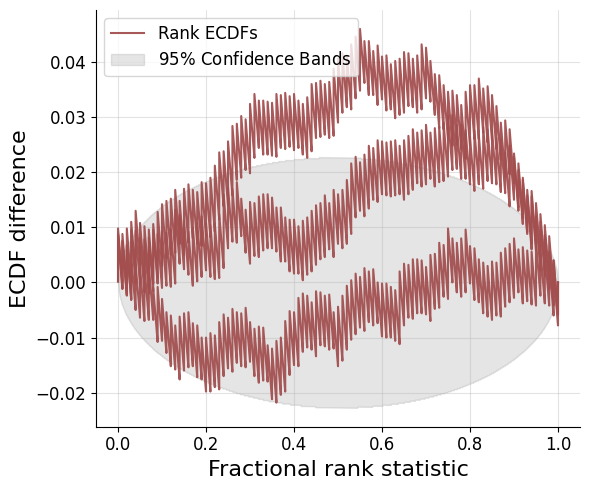

In [18]:
f = diag.plot_sbc_ecdf(
    post_samples, validation_sims["parameters"], stacked=True, difference=True, legend_fontsize=12, fig_size=(6, 5)
)

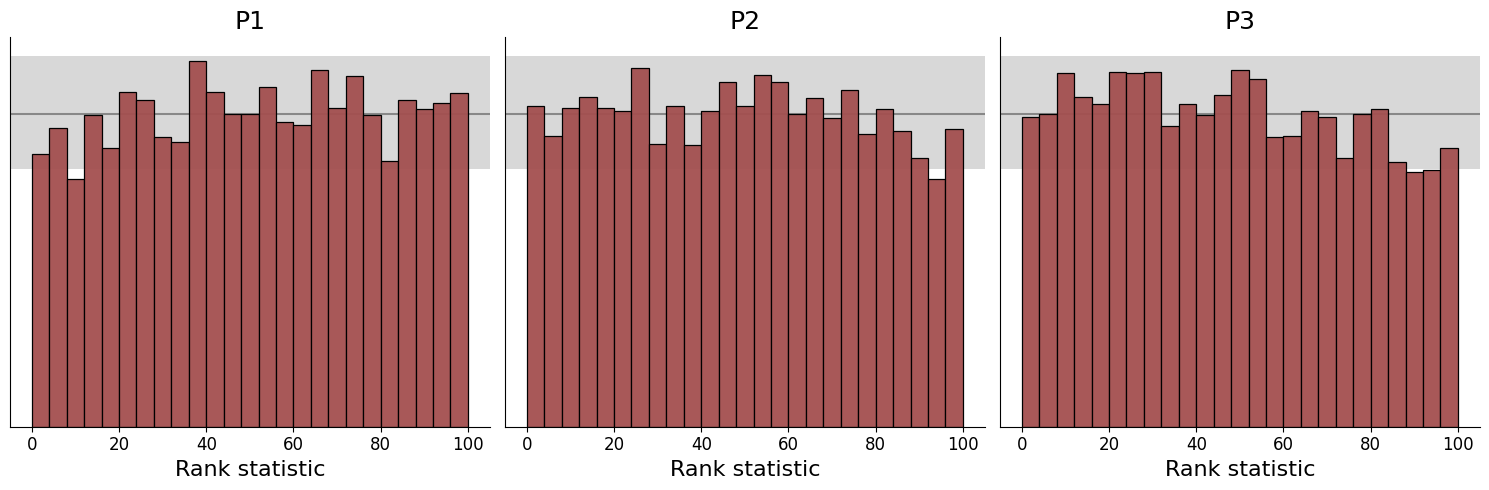

In [19]:
f = diag.plot_sbc_histograms(post_samples, validation_sims["parameters"], param_names=prior.param_names)

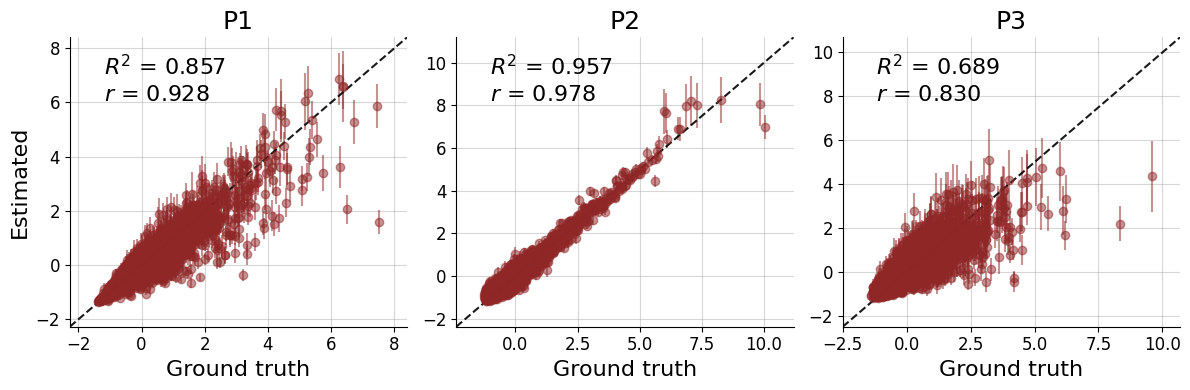

In [20]:
from diagnostics import plot_recovery

post_samples = amortizer.sample(validation_sims, n_samples=1000)
f = diag.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)